In [1]:
using StateSpaceDynamics, Plots


In [2]:
model = initialize_slds()

SwitchingLinearDynamicalSystem([0.96 0.04; 0.04 0.96], StateSpaceDynamics.LinearDynamicalSystem[StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([0.9452539570141245 -0.09484174581448675; 0.09484174581448675 0.9452539570141245], [0.001 0.0; 0.0 0.001], [0.0, 0.0], [0.001 0.0; 0.0 0.001]), StateSpaceDynamics.GaussianObservationModel{Float64}([-0.31498797116895605 0.4338858743048611; -0.31125240132442067 -0.3954398407537453; … ; -0.8253345499750688 -0.9654904870197227; 0.840288523245819 0.9656607495563969], [0.001 0.0 … 0.0 0.0; 0.0 0.001 … 0.0 0.0; … ; 0.0 0.0 … 0.001 0.0; 0.0 0.0 … 0.0 0.001]), 2, 10, Bool[1, 1, 1, 1, 1, 1]), StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([-0.39533949471978524 -0.86383255548

In [3]:
T = 1000
# Generate synthetic data
x, y, z = sample(model, T)


([0.012781148406102944 -0.043551433682513074 … 0.009189945184785569 0.03215941558734649; 0.03788281101630884 -0.021698572664429976 … -0.08498702535863965 -0.10696223889695361], [-0.0037362031674817945 0.011184638740456908 … -0.07094318488635357 -0.05032349162445888; 0.01979088919057409 0.030620168627788782 … 0.03078518538867422 0.0675583423786563; … ; -0.06176123606409473 0.086548578688241 … 0.13735992748512493 0.03213684839745743; 0.042094688716242876 -0.10110240825174423 … -0.0663617447355249 -0.08508079724902799], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

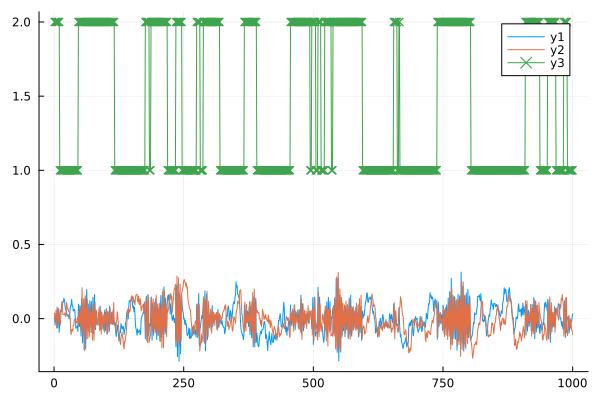

In [4]:
plot(x')
plot!(z, marker=:x)

In [5]:
using LinearAlgebra

p = model.B[1].obs_dim
d = model.B[1].latent_dim

K = model.K
A = [0.9 0.1; 0.2 0.8]
A ./= sum(A, dims=2) # Normalize rows to sum to 1

πₖ = rand(K)
πₖ ./= sum(πₖ) # Normalize to sum to 1

Q = Matrix(0.5 * I(d))

x0 = [0.0; 0.0]
P0 = Matrix(0.5 * I(d))

# set up the observation parameters
C = randn(p, d)
R = Matrix(0.001 * I(p))

B = [StateSpaceDynamics.LinearDynamicalSystem(
    StateSpaceDynamics.GaussianStateModel(0.95 * [cos(f) -sin(f); sin(f) cos(f)], Q, x0, P0),
    StateSpaceDynamics.GaussianObservationModel(C, R),
    d, p, fill(true, 6  )) for (i,f) in zip(1:K, [0.5, 0.5])]

modeli = SwitchingLinearDynamicalSystem(A, B, πₖ, model.K)

SwitchingLinearDynamicalSystem([0.9 0.1; 0.2 0.8], StateSpaceDynamics.LinearDynamicalSystem[StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([0.8337034337958541 -0.45545426167399283; 0.45545426167399283 0.8337034337958541], [0.5 0.0; 0.0 0.5], [0.0, 0.0], [0.5 0.0; 0.0 0.5]), StateSpaceDynamics.GaussianObservationModel{Float64}([-1.26568024925137 -0.9976332962608697; 1.4083219913311036 -0.33858277830853944; … ; 0.11964081053499176 1.0222783516680272; 0.6740889070887084 2.1655506694970224], [0.001 0.0 … 0.0 0.0; 0.0 0.001 … 0.0 0.0; … ; 0.0 0.0 … 0.001 0.0; 0.0 0.0 … 0.0 0.001]), 2, 10, Bool[1, 1, 1, 1, 1, 1]), StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([0.8337034337958541 -0.45545426167399283; 0.4554542

In [6]:
FB = StateSpaceDynamics.initialize_forward_backward(modeli, T)
FS = [StateSpaceDynamics.initialize_FilterSmooth(modeli.B[k], T) for k in 1:K]

ml = zeros(100,1)
for i in 1:length(ml)
    ml[i] = variational_expectation!(modeli, y, FB, FS)  
end

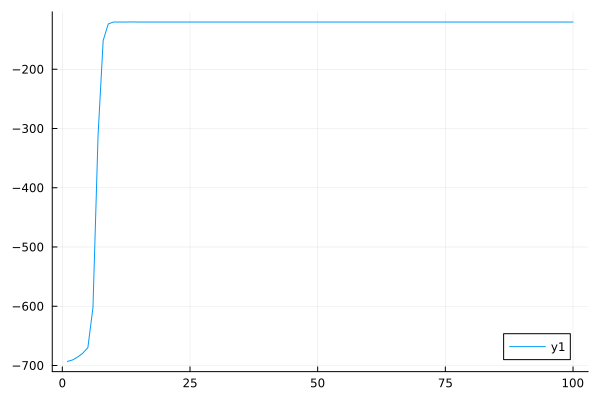

In [7]:
plot(ml)

In [8]:
mls, param_diff, FB, FS = fit!(modeli, y; max_iter=50)

Fitting SLDS via vEM...   4%|██                                                |  ETA: 0:00:57 ( 1.18  s/it)

CompositeException: TaskFailedException

    nested task error: PosDefException: matrix is not positive definite; Cholesky factorization failed.
    Stacktrace:
     [1] checkpositivedefinite
       @ ~/.julia/juliaup/julia-1.10.4+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/LinearAlgebra/src/factorization.jl:67 [inlined]
     [2] cholesky!(A::Symmetric{Float64, Matrix{Float64}}, ::NoPivot; check::Bool)
       @ LinearAlgebra ~/.julia/juliaup/julia-1.10.4+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/LinearAlgebra/src/cholesky.jl:269
     [3] cholesky! (repeats 2 times)
       @ ~/.julia/juliaup/julia-1.10.4+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/LinearAlgebra/src/cholesky.jl:267 [inlined]
     [4] cholesky(A::Symmetric{Float64, Matrix{Float64}}, ::NoPivot; check::Bool)
       @ LinearAlgebra ~/.julia/juliaup/julia-1.10.4+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/LinearAlgebra/src/cholesky.jl:401
     [5] cholesky (repeats 2 times)
       @ ~/.julia/juliaup/julia-1.10.4+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/LinearAlgebra/src/cholesky.jl:401 [inlined]
     [6] macro expansion
       @ ~/Documents/GitHub/StateSpaceDynamics.jl/src/SLDS.jl:307 [inlined]
     [7] (::StateSpaceDynamics.var"#223#threadsfor_fun#58"{StateSpaceDynamics.var"#223#threadsfor_fun#56#59"{Vector{StateSpaceDynamics.GaussianObservationModel{Float64}}, Matrix{Float64}, Vector{StateSpaceDynamics.FilterSmooth{Float64}}, Int64, Matrix{Float64}, UnitRange{Int64}}})(tid::Int64; onethread::Bool)
       @ StateSpaceDynamics ./threadingconstructs.jl:215
     [8] #223#threadsfor_fun
       @ ./threadingconstructs.jl:182 [inlined]
     [9] (::Base.Threads.var"#1#2"{StateSpaceDynamics.var"#223#threadsfor_fun#58"{StateSpaceDynamics.var"#223#threadsfor_fun#56#59"{Vector{StateSpaceDynamics.GaussianObservationModel{Float64}}, Matrix{Float64}, Vector{StateSpaceDynamics.FilterSmooth{Float64}}, Int64, Matrix{Float64}, UnitRange{Int64}}}, Int64})()
       @ Base.Threads ./threadingconstructs.jl:154

In [9]:
model.A

2×2 Matrix{Float64}:
 0.96  0.04
 0.04  0.96

In [10]:
modeli.A

2×2 Matrix{Float64}:
 1.0  5.70998e-8
 1.0  0.0

In [11]:
plot(mls)

UndefVarError: UndefVarError: `mls` not defined

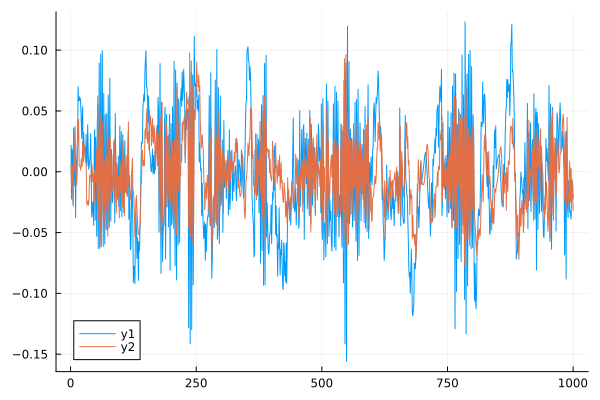

In [12]:
plot(FS[1].x_smooth')

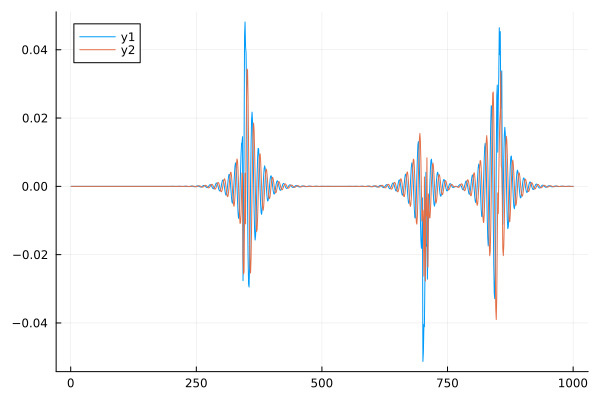

In [13]:
plot(FS[2].x_smooth')

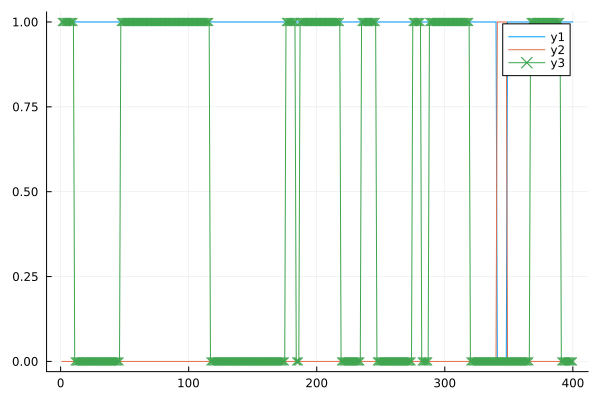

In [14]:
plot(exp.(FB.γ[:,1:400])')
plot!(z[1:400] .- 1, marker=:x)

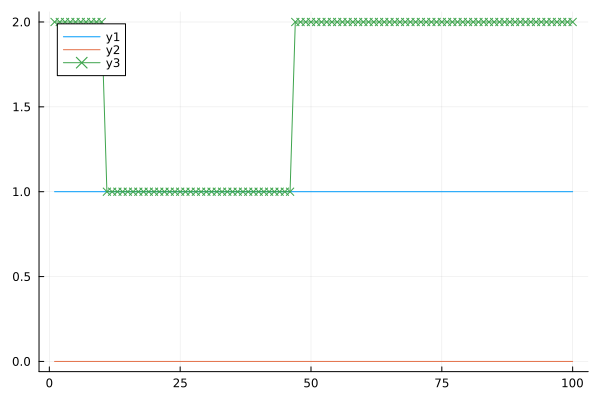

In [15]:
plot(exp.(FB.loglikelihoods[:,1:100])')
plot!(z[1:100], marker=:x)

In [16]:
plot(param_diff)

UndefVarError: UndefVarError: `param_diff` not defined